## KDEs for time series

To illustrate the `kdetools` API, adapt a `statsmodels` tutorial on vector autoregression (https://www.statsmodels.org/stable/vector_ar.html) then fit a KDE model to the same data.

In [2]:
import numpy as np
import scipy.stats as st
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Extended KDE functions
import kdetools as kt

Load and preprocess the data:

In [3]:
mdata = sm.datasets.macrodata.load_pandas().data
mdata = mdata[['realgdp','realcons','realinv']]
data = np.log(mdata).diff().dropna()
data.head(2)

,realgdp,realcons,realinv
1,0.024942,0.015286,0.080213
2,-0.001193,0.010386,-0.072131


Model the deltas as a Markov process:

In [4]:
X = pd.concat([data, data.diff().shift(-1).add_prefix('delta_')], axis=1).dropna()
X.head()

,realgdp,realcons,realinv,delta_realgdp,delta_realcons,delta_realinv
1,0.024942,0.015286,0.080213,-0.026135,-0.004900,-0.152344
2,-0.001193,0.010386,-0.072131,0.004687,-0.009302,0.106556
3,0.003495,0.001084,0.034425,0.018696,0.008450,0.068239
4,0.022190,0.009534,0.102664,-0.026875,0.003038,-0.209358
5,-0.004685,0.012572,-0.106694,0.006317,-0.016540,0.100716


Visualise the data dependency structure:

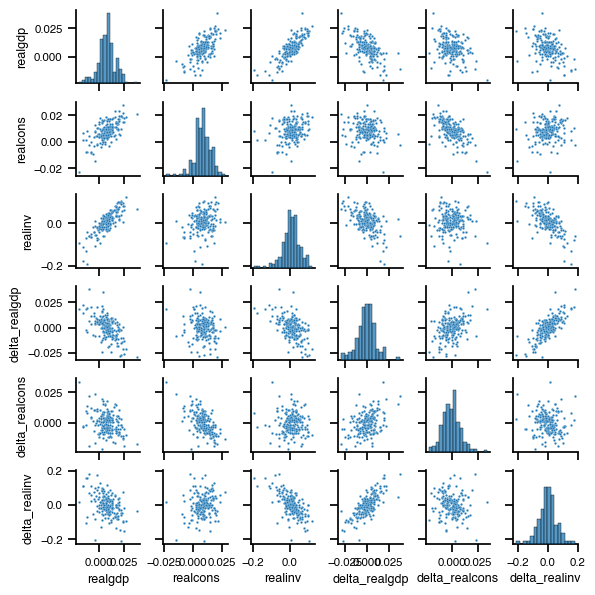

In [5]:
sns.set_context('notebook', font_scale=0.75)
sns.pairplot(X, height=1, plot_kws={'s': 3});

### Fit KDE model to data and simulate

To fit the KDE model reuse the `X` DataFrame, fitting a 6-dimensional KDE, noting that the base `gaussian_kde` class expects data with features as rows and instances as columns, hence the transpose:

In [6]:
kde = kt.gaussian_kde(X.T)
kde.factor

0.5884104732889696

In [7]:
kde.set_bandwidth('cv', bw_type='covariance')
kde.factor

array([0.72350355])

Define an array to store the results,  populate with the initial value of the training data and run time-stepping loop:

In [8]:
np.random.seed(42)
N = 200
kde_sim = np.zeros((N, 3))
kde_sim[0] = data.iloc[0,:]

for i in range(1, N):
    x_cond = kde_sim[i-1:i].ravel()[None,:]
    kde_sim[i] = kde_sim[i-1] + kde.conditional_resample(1, x_cond=x_cond, dims_cond=[0,1,2])

kde_sim = pd.DataFrame(kde_sim, columns=data.columns).add_suffix('_KDE')

##### Visualise the simulated results

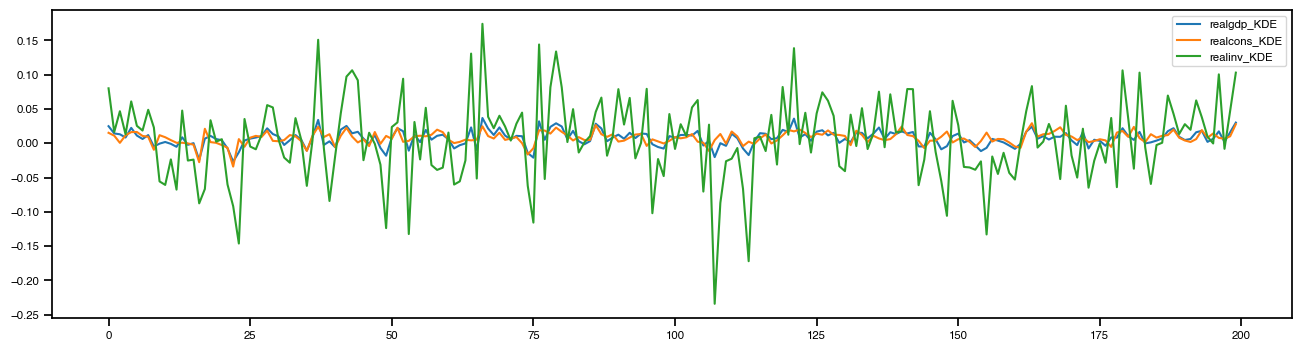

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
kde_sim.plot(ax=ax);

##### Compare the summary statistics:

In [10]:
pd.concat({'data': data.describe(), 'KDE': kde_sim.describe()}, axis=1)

data                                 KDE                         
          realgdp    realcons     realinv realgdp_KDE realcons_KDE realinv_KDE
count  202.000000  202.000000  202.000000  200.000000   200.000000  200.000000
mean     0.007758    0.008368    0.008143    0.007580     0.007828    0.005995
std      0.008798    0.006944    0.046848    0.011037     0.008842    0.059993
min     -0.020708   -0.022955   -0.193163   -0.026664    -0.033981   -0.234200
25%      0.003345    0.004409   -0.015160    0.001266     0.002935   -0.026874
50%      0.007652    0.008525    0.010199    0.007520     0.008265    0.005923
75%      0.012730    0.012831    0.034959    0.014605     0.013174    0.044167
max      0.038585    0.027733    0.122094    0.036927     0.029274    0.174336

##### Compare correlation matrices

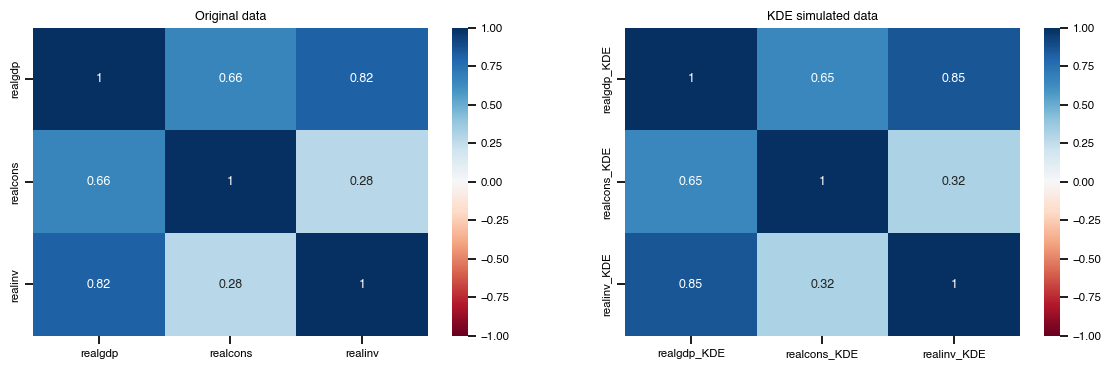

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
sns.heatmap(data.corr(), ax=ax1, vmin=-1, vmax=1, cmap='RdBu', annot=True); ax1.set_title('Original data')
sns.heatmap(kde_sim.corr(), ax=ax2, vmin=-1, vmax=1, cmap='RdBu', annot=True); ax2.set_title('KDE simulated data');

##### Calculate 2-sample Kolmogorov-Smirnov p-values between the original data and the KDE-simulated data:

In [12]:
for v in data.columns:
    print(f'{v:8} KDE = {st.ks_2samp(data[v], kde_sim[f"{v}_KDE"]).pvalue:.4f}')

realgdp  KDE = 0.2240
realcons KDE = 0.1868
realinv  KDE = 0.0894


##### Compare ECDFs

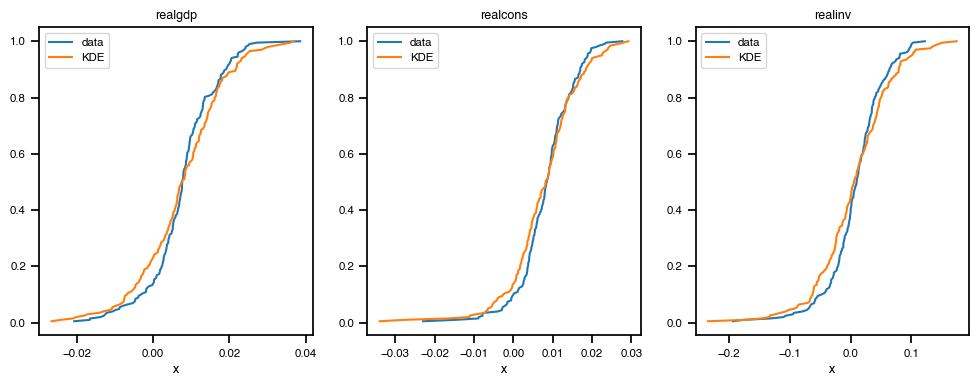

In [13]:
ecdf = kt.kdecdf()

fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i in range(3):
    ax = axes[i]
    v = data.columns[i]
    pd.DataFrame({'x': data[v], 'ecdf': ecdf.calc_ecdf(data[v])}).sort_values('x').plot('x', 'ecdf', label='data', ax=ax)
    pd.DataFrame({'x': kde_sim[f'{v}_KDE'], 'ecdf': ecdf.calc_ecdf(kde_sim[f'{v}_KDE'])}).sort_values('x').plot('x', 'ecdf', label='KDE', ax=ax)
    ax.set_title(v);